<a href="https://colab.research.google.com/github/DmitriyValetov/nlp_course_project/blob/master/main_transformer_abae_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
config = {
    'd_model': 200,
    'aspects_num': 50,
    'nhead': 4, # 8,
    'num_encoder_layers': 3, # 6
    'num_decoder_layers': 3, # 6
    'dim_feedforward': 2048,
    'pos_dropout': 0.2,
    'trans_dropout': 0.2,
    'batch_size': 64,
}

import os
root = "drive/My Drive"
texts_path = os.path.join(root, "stop_lem_norm_sents_ria.json.gz")

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
!pip install pymorphy2
!pip install einops

     |████████████████████████████████| 51kB 1.7MB/s 
     |████████████████████████████████| 7.1MB 4.2MB/s 


In [4]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt


from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
from collections import defaultdict
import numpy as np
from einops import rearrange

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.datasets import fetch_20newsgroups

from nltk import word_tokenize
from nltk.tokenize import sent_tokenize, word_tokenize

import pymorphy2
import re


import os
import gzip
import time
import json
import tqdm
from bs4 import BeautifulSoup

import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device}")


def save_texts(texts, titles, filename):
  dump_texts = os.path.join(root, filename)
  with open(file=dump_texts, mode='w') as f:
    json.dump({'texts': texts, 'titles': titles}, f)

def load_texts(filename):
  dump_texts = os.path.join(root, filename)
  with open(file=dump_texts, mode='r') as f:
    data = json.load(f)
  return data['texts'], data['titles']

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
Using cuda


# Preprocess ria news

In [0]:
# new
lines = []
with gzip.open(texts_path, 'rb') as f:
  for line in tqdm.tqdm(f):
    lines.append(json.loads(line))

1003869it [00:44, 22672.49it/s]


In [0]:
print(len(lines))
lines = list(filter(lambda x: len(x['title'])!=0 and len(x['title'][0])>0 and len(x['text'])>1 and len(x['text'][1])>0, lines))
print(len(lines))

1003869
994580


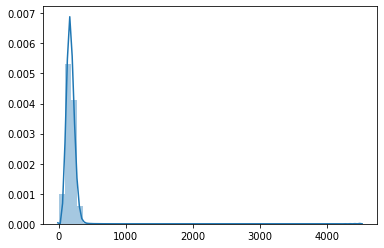

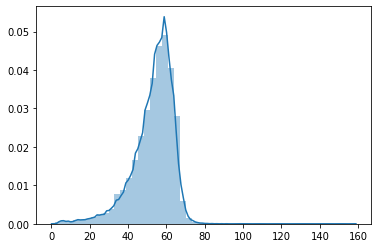

In [0]:
lens = [len(l['text'][1]) for l in lines]
sns.distplot(lens)
plt.show()
plt.close()

lens = [len(l['title'][0]) for l in lines]
sns.distplot(lens)
plt.show()
plt.close()

In [0]:
print(len(lines))
lines = list(filter(lambda x: len(x['text'])!=0 and len(x['title'][0])<70 and len(x['title'][0])>30 and len(x['text'])>1 and len(x['text'][1])>5 and len(x['text'][1])<400, lines))
print(len(lines))

994580
942825


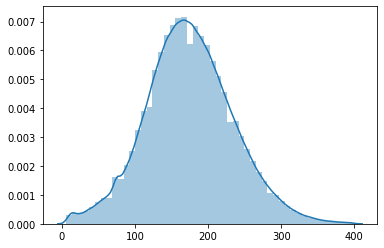

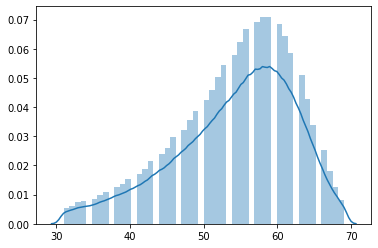

In [0]:
lens = [len(l['text'][1]) for l in lines]
sns.distplot(lens)
plt.show()
plt.close()

lens = [len(l['title'][0]) for l in lines]
sns.distplot(lens)
plt.show()
plt.close()

In [0]:
print(len(lines))
lines = lines[:100000]
print(len(lines))

942825
100000


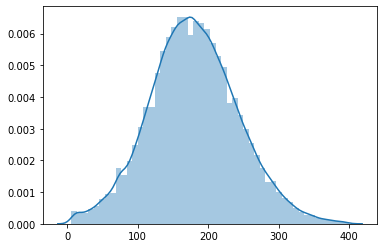

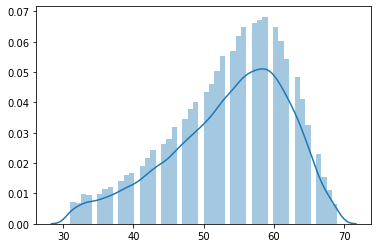

In [0]:
lens = [len(l['text'][1]) for l in lines]
sns.distplot(lens)
plt.show()
plt.close()

lens = [len(l['title'][0]) for l in lines]
sns.distplot(lens)
plt.show()
plt.close()

In [0]:
morph = pymorphy2.MorphAnalyzer()
pattern = re.compile("^[а-яА-Я]+$")

texts = []
titles = []

def process_sentence(sentence):
    words = [w for w in nltk.word_tokenize(sentence) if w not in stopwords.words("russian") and pattern.match(w)]
    words = [morph.parse(word)[0].normal_form.lower() for word in words]
    return words

for line_i in tqdm.tqdm(range(len(lines))):
    text  = lines[line_i]['text'][1] # [0] - is a paper name and date
    title = lines[line_i]['title'][0]
    processed_text = process_sentence(text)
    processed_title = process_sentence(title)
    texts.append(processed_text)
    titles.append(processed_title)

100%|██████████| 100000/100000 [11:08<00:00, 149.48it/s]


In [0]:
save_texts(texts, titles, "ria_text_titles.json")

# Load data

271
Read 98061 sentence pairs
Counted words:
ru 54851
[['заместитель', 'мэр', 'москва', 'столичный', 'правительство', 'людмила', 'швецов', 'принять', 'участие', 'работа', 'международный', 'женский', 'форум', 'сша', 'обсудить', 'вопрос', 'инновационный', 'развитие', 'сообщить', 'риа', 'новость', 'пятница', 'городской', 'комплекс', 'социальный', 'сфера'], ['людмила', 'швецов', 'обсудить', 'инновационный', 'развитие', 'форум', 'сша']]
['француз', 'гаэль', 'монфис', 'сыграть', 'словак', 'доминик', 'хрбат', 'первое', 'круг', 'турнир', 'йоханнесбург', 'который', 'стартовать', 'февраль', 'сообщать', 'официальный', 'сайт', 'ассоциация', 'атр']
['монфис', 'испытать', 'словацкий', 'ветеран', 'хрбат', 'старт', 'турнир', 'юар']
271


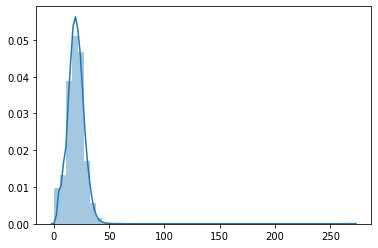

In [5]:
texts, titles = load_texts("ria_text_titles.json") #
# texts, titles = texts[:30000], titles[:30000]
print(max([len(t) for t in texts]))



SOS_token = 0 # start of string.
EOS_token = 1 # end of string.
PAD_token = 2
UNK_token = 3

class Lang: # like a vocabulary
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": SOS_token, "EOS": EOS_token, "PAD": PAD_token, 'UNK': UNK_token}
        self.word2count = {}
        self.index2word = {SOS_token: "SOS", EOS_token: "EOS", PAD_token: "PAD", UNK_token: "UNK"}
        self.n_words = len(self.word2index)
        self.max_seq_length = None

    def addSentence(self, sentence):
        if self.max_seq_length is None:
          self.max_seq_length = len(sentence)
        elif self.max_seq_length < len(sentence):
          self.max_seq_length = len(sentence)
        for word in sentence:
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

    def tensor2text(self, tensor):
        return [self.index2word[token.item()] for token in tensor]
        
    def ids2text(self, numbers):
      return [self.index2word[num] for num in numbers]

    def text2ids(self, tokens):
        return [self.word2index[token] if token in self.word2index else self.word2index['UNK'] for token in tokens]
            
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s



def prepareData(texts, titles):
    pairs = [[txt, ttl] for txt, ttl in zip(texts, titles) if len(txt)>0 and len(ttl)>0 ]
    lang = Lang('ru')

    print("Read %s sentence pairs" % len(pairs))
    for pair in pairs:
        lang.addSentence(pair[0])
        lang.addSentence(pair[1])
    print("Counted words:")
    print(lang.name, lang.n_words)
    return lang, pairs

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(lang, pair[0])
    target_tensor_t = tensorFromSentence(lang, pair[1][:-1])
    target_tensor_l = tensorFromSentence(lang, pair[1])
    return (input_tensor, target_tensor_t, target_tensor_l)


lang, pairs = prepareData(texts, titles)
print(random.choice(pairs))

lens = [len(t) for t in texts]
sns.distplot(lens)

i = 100
print(texts[i])
print(titles[i])
print(lang.max_seq_length)

# Datasets

In [0]:
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader


class HeadlinesDataset(Dataset):
    def __init__(self, pairs, lang, batch_size):
        self.pairs = pairs
        self.lang = lang
        self.batch_size = batch_size
        self.batch_num = len(self.pairs)//batch_size
        
    def __getitem__(self, index): # todo: make number of pads depend on current batch max text, title length
        srcs = []
        srcs_lns = []
        tgts = []
        tgts_lns = []
        for i in range(self.batch_size):
          src, tgt = self.pairs[index*self.batch_size+i]
          srcs.append(src)
          srcs_lns.append(len(src))
          tgts.append(tgt)
          tgts_lns.append(len(tgt))

        max_src_ln = max(srcs_lns)          
        max_tgt_ln = max(tgts_lns)    

        converted_srcs = []    
        converted_tgts = []    
        srcs_padding_masks = []
        tgts_padding_masks = []

        for i in range(len(srcs)):
          converted_srcs.append(self.lang.text2ids(srcs[i]) + [self.lang.word2index['PAD']]*(max_src_ln-len(srcs[i]))) 
          srcs_padding_masks.append([False] + [False]*len(srcs[i]) + [True]*(max_src_ln-len(srcs[i]))) # first for intent

          converted_tgts.append(
              [self.lang.word2index['SOS']] + 
                self.lang.text2ids(tgts[i]) + 
              [self.lang.word2index['EOS']] + 
              [self.lang.word2index['PAD']]*(max_tgt_ln-len(tgts[i]))
              ) 
          tgts_padding_masks.append([False]*(len(tgts[i])+2) + [True]*(max_tgt_ln-len(tgts[i])))

        return (srcs_lns, np.array(converted_srcs), np.array(converted_tgts), np.array(srcs_padding_masks), np.array(tgts_padding_masks))

    def __len__(self):
        return self.batch_num


# train_dataset = HeadlinesDataset(pairs[1024:], lang, batch_size=config['batch_size'])
# test_dataset  = HeadlinesDataset(pairs[:1024], lang, batch_size=config['batch_size'])

# train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
# test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

# src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(train_loader))
# src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(test_loader))
# print(src)
# print(tgt)
# print(src_key_padding_mask)
# print(tgt_key_padding_mask)

In [0]:
class ABAEDataset(Dataset):
    def __init__(self, pairs, lang, m):
        self.m = m
        self.lang = lang
        self.pairs = pairs # [p[0] for p in pairs] + [p[1] for p in pairs]
        assert(self.m+1<len(self.pairs))

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        ps = self.pairs[idx][0]
        ns_i = random.sample(range(len(self)), self.m)
        ns = [self.pairs[i][0] for i in ns_i]
        ps = self.lang.text2ids(ps)
        ns = [self.lang.text2ids(s) for s in ns]
        return ps, ns


def collate_fn(batch):
    ps_list = [b[0] for b in batch]
    ns_lists = [b[1] for b in batch]
    return ps_list, ns_lists


# ds = ABAEDataset(pairs, lang, 20)
# dataloader = DataLoader(ds, batch_size=3, collate_fn=collate_fn)
# btch = next(iter(dataloader))
# print(len(btch[0]))
# print(len(btch[1]))

# Prepear word embeddings

In [0]:
config = {
    'd_model': 512,
    'aspects_num': 100,
    'abae_regilarize': 0.000001,
    'batch_size': 64,
    'abae_negative_m': 20,
    'nhead': 4, # 8,
    'num_encoder_layers': 3, # 6
    'num_decoder_layers': 3, # 6
    'dim_feedforward': 2048,
    'pos_dropout': 0.2,
    'trans_dropout': 0.2,
    'n_warmup_steps': 4000,
}

In [9]:
from random import shuffle

union = []
for pair in tqdm.tqdm(pairs):
  union.append(['SOS']+pair[0]+['EOS']+['PAD']+['UNK'])
  # union.append(['SOS']+pair[1]+['EOS']+['PAD']+['UNK'])

shuffle(union)


from gensim.models.word2vec import Word2Vec
from multiprocessing import cpu_count

model = Word2Vec(union, 
                 min_count = 0, 
                 workers=cpu_count(),
                 size=config['d_model'],
                 window=10,
                 negative=5,
                #  iter=100
                )


init_voc = set(lang.word2index.keys())
wv_voc = set(model.wv.vocab.keys())
print(len(wv_voc), len(init_voc))
print(wv_voc - init_voc)
print(init_voc - wv_voc)
# assert(len(init_voc)==len(wv_voc))


word_init_vectors = {}
for w in model.wv.vocab:
    word_init_vectors[w] = model[w].tolist()

100%|██████████| 98061/98061 [00:00<00:00, 231168.30it/s]


51073 54851
set()
{'пересдавать', 'подвластный', 'путоран', 'букридер', 'бесперебойность', 'спусковой', 'плодотворно', 'умолчать', 'незаметный', 'свист', 'госскидка', 'прокручивать', 'жмудь', 'первокурсник', 'пропануть', 'униформа', 'пханмуна', 'марганец', 'зародыш', 'зоотерапия', 'совершениия', 'экобезопасность', 'санаева', 'лунгин', 'мурманчанин', 'активированный', 'располнеть', 'тиллман', 'ногальский', 'костюмерный', 'глэйзеры', 'соципотека', 'шезлонг', 'неработать', 'изготовитель', 'бауржан', 'спасработа', 'глубинка', 'нацгвардия', 'ляпко', 'ходячий', 'плац', 'учатие', 'экономсоюз', 'грешник', 'разорить', 'мэдоффома', 'турмаршрут', 'соцстабильность', 'спецструктура', 'вратарский', 'фантастически', 'впустить', 'телеправо', 'неискренность', 'марафонец', 'санавиация', 'валер', 'ял', 'замглавый', 'древнеэскимосский', 'адаптивный', 'перстень', 'добирать', 'ленг', 'жуйков', 'профицитный', 'тубдиспансер', 'подчинить', 'кулясова', 'морпех', 'полыгалов', 'иммигрантский', 'матпомощь', 'отмач

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


# Prepear aspects vectors

380


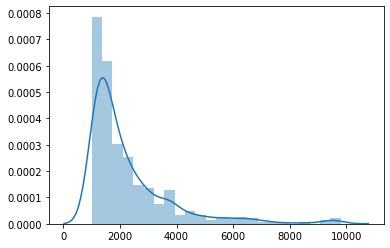

In [11]:
lens = [lang.word2count[w] for w in lang.word2count]
print(len([w for w in lang.word2count if lang.word2count[w] > 1000 and lang.word2count[w] < 5000]))
sns.distplot([l for l in lens if l > 1000 and l < 10000])
plt.show()

In [12]:
X = []
words = []
for w in lang.word2count:
    if lang.word2count[w] > 1000 and lang.word2count[w] < 5000:
        X.append(word_init_vectors[w])
        words.append(w)
print(len(words))


# K means
from sklearn.cluster import KMeans
import numpy as np
kmeans = KMeans(n_clusters=config['aspects_num'], n_init=10, max_iter=500, random_state=42, verbose=0).fit(X)
av = kmeans.cluster_centers_.tolist()


def sim(word, aspect):
    return np.dot(word, aspect)

def sim2(word, aspect):
    return np.sum((word-aspect)**2)

neares_num = 100
for aspect_i in range(len(av)):
    aspect = np.array(av[aspect_i])
    similarities = []
    for word_i in range(len(X)):
        word = words[word_i]
        similarities.append([word, sim(X[word_i], aspect)])
    
    low_words = sorted(similarities, key=lambda x: x[1])[:neares_num]
    print(aspect_i, [w[0] for w in low_words])

380
0 ['пресс', 'судебный', 'евро', 'газета', 'дата', 'скп', 'больница', 'турнир', 'рейтер', 'андрей', 'телеканал', 'тренер', 'спорт', 'зал', 'гувд', 'источник', 'информация', 'сми', 'ссылка', 'полиция', 'доллар', 'обвинять', 'евгений', 'мчс', 'теннисный', 'служба', 'землетрясение', 'фон', 'биржа', 'отдел', 'интервью', 'жизнь', 'финал', 'алексей', 'торг', 'департамент', 'начальник', 'составлять', 'лига', 'чемпион', 'опубликовать', 'цена', 'свидетельствовать', 'сообщаться', 'главный', 'следственный', 'местный', 'выиграть', 'министерство', 'передавать', 'игорь', 'образование', 'остаться', 'убийство', 'курс', 'украинский', 'кубок', 'выйти', 'николай', 'культура', 'политика', 'сайт', 'испания', 'администрация', 'греция', 'правоохранительный', 'сборный', 'банка', 'областной', 'руководитель', 'футболист', 'ванкувер', 'экономика', 'школа', 'подозревать', 'сообщение', 'аэропорт', 'китай', 'прокуратура', 'рост', 'вод', 'михаил', 'директор', 'появиться', 'вырастить', 'франс', 'ведомство', 'соста

# Model

In [0]:
import math 
# Source: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=200):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)


class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr


def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

class ConditionalHeadlineGenerator(nn.Module):
    def __init__(self, lang, device, vocab_size, max_seq_length, d_model, aspects_num, abae_regilarize, batch_size,  
                 abae_negative_m, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, pos_dropout, trans_dropout):
        super().__init__()
        # Constants
        self.lang = lang
        self.device = device
        self.d_model = d_model
        self.vocab_size = vocab_size
        self.aspects_num = aspects_num
        self.abae_regilarize = abae_regilarize
        self.abae_negative_m = abae_negative_m
        self.batch_size = batch_size

        self.max_seq_length = max_seq_length
        
        # auto .parameters()
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.embed_src = nn.Embedding(vocab_size, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)
        self.fc = nn.Linear(d_model, vocab_size)
        self.w_embs = self.embed_src # abae
        self.sentence_aspects = torch.nn.Linear(d_model, aspects_num) # abae

        # needs to be added to optimizer
        self.a_embs = torch.randn(aspects_num, d_model, requires_grad=True, device=device) # abae
        self.attention_M = torch.randn(d_model, d_model, requires_grad=True, device=device) # abae

        # other staff
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length+1) # +1 for first conditional token
        self.criterion = nn.CrossEntropyLoss(ignore_index=self.lang.word2index['PAD'])
        self.optimizer = None

        #set device
        self.to(self.device)



    def tgt_emb(self, tgt):
        return self.embed_src(tgt)


    def src_emb(self, src): # for T and abae
        return self.embed_src(src)


    def make_sentence(self, embs):
        """
        input: embedded words
        output: weights
        """
        ys = torch.mean(embs, axis=0).unsqueeze(dim=1)
        # print(self.attention_M.shape) # torch.Size([300, 300])
        # print(ys.shape) # torch.Size([300, 1])
        # print(torch.mm(self.attention_M, ys).shape) # torch.Size([300, 1])
        # print(embs.shape) # torch.Size([19, 300])
        di = torch.mm(embs, torch.mm(self.attention_M, ys)) # [seq_len, dim] [[dim, dim] [dim, 1]]
        ai = torch.nn.functional.softmax(di, dim=1)
        zs = torch.mm(embs.T, ai)
        return zs


    def add_major_aspect(self, srcs_lns, src):
        """
        input: embedded sentences [Batch, seq len, dim]
        output: embedded words hstasked with aspect vectors [Batch, 1+seq len, dim]
        """
        av = torch.zeros(src.shape[0], 1, src.shape[2]).to(self.device) # [Batch, dim]
        for i in range(src.shape[0]):
          ys = torch.mean(src[i, :srcs_lns[i], :], axis=0).unsqueeze(dim=1) # [dim, 1]
          di = torch.mm(src[i, :srcs_lns[i], :], torch.mm(self.attention_M, ys)) # [seq_len, dim] [[dim, dim] [dim, 1]]
          ai = torch.nn.functional.softmax(di, dim=1) # [seq_len, 1]
          zs = torch.mm(src[i, :srcs_lns[i], :].T, ai) # [dim, 1]
          pt = torch.nn.functional.softmax(self.sentence_aspects(zs.T), dim=1).T # [apects num, 1]
          av[i, 0, :] = self.a_embs[torch.argmax(pt)]
        src = torch.cat([av, src], dim=1) # Batch, 1+seq len, dim]
        return src # [Batch, 1+seq len, dim]


    def init_embeddings(self, wv): # abae
        assert(self.embed_src.weight.data.shape == wv.shape)
        assert(self.embed_tgt.weight.data.shape == wv.shape)
        self.embed_src.weight.data = wv
        self.embed_tgt.weight.data = wv


    def make_sentence_raw(self, embs): # abae
        return torch.mean(embs, axis=0).unsqueeze(dim=1)


    def abae_forward(self, ps, ns_list):
        """
        ps - positive sequence. Tensor of shape (sentence_length,)
        ns_list - list of negaitve sequence. Tensor of shape [(sentence_length,), ...]
        """
        embs = self.w_embs(ps) # (sentence_length, emb_dim)
        zs = self.make_sentence(embs) # sentence from attentioned words vectors
        pt = torch.nn.functional.softmax(self.sentence_aspects(zs.T), dim=1).T
        rs = torch.mm(self.a_embs.T, pt) # sentence reconstraction by aspects vectors
        return rs, zs, [self.make_sentence_raw(self.w_embs(ns)) for ns in ns_list]


    def abae_step(self, b_ps, b_ns):
        """
        No grad zero here.
        Input:
        --------
        b_ps batch of positive sentences
        b_ns batch of lists of negative sentances
        """
        batch_loss = torch.Tensor([[0.0]]).to(self.device)
        for b_s in range(len(b_ps)):
            ps = torch.Tensor(b_ps[b_s]).long().to(self.device)
            ns_list = [torch.Tensor(ns).long().to(self.device) for ns in b_ns[b_s]]
            rs, ps, ns_list = self.abae_forward(ps, ns_list)
            sample_loss = torch.Tensor([[1.0]]).to(self.device)
            sample_loss -= torch.mm(rs.T, ps).to(self.device)
            for ns in ns_list:
                sample_loss += torch.mm(rs.T, ns).to(self.device)
            if sample_loss > 0:
                batch_loss += sample_loss
        batch_loss += self.abae_regilarize*torch.norm(torch.mm(self.a_embs, self.a_embs.T)-torch.eye(self.a_embs.shape[0]).to(self.device))
        return batch_loss


    def abae_train(self, pairs, epochs_n, progress_bar=False, logging=False, dataset_shuffle=False):
        """
        Be carefull ro turn your parameters into 
        train phase before launching this.
        """
        abae_dataset = ABAEDataset(pairs, self.lang, self.abae_negative_m)
        losses = []
        for epoch_i in range(epochs_n):
            abae_dataloader = DataLoader(abae_dataset, 
                                         batch_size=self.batch_size, 
                                         collate_fn=collate_fn,
                                         shuffle=dataset_shuffle)
            epoch_loss = torch.Tensor([[0.0]]).to(self.device)
            for b_ps, b_ns in tqdm.tqdm(abae_dataloader, disable=(not progress_bar)):
                self.optimizer.zero_grad()
                batch_loss = self.abae_step(b_ps, b_ns)
                epoch_loss += batch_loss.item()
                batch_loss.backward()
                self.optimizer.step()          
            losses.append((epoch_i, epoch_loss.item()))
            if logging:
                print(f"ABAE train epoch: {epoch_i} - loss: {epoch_loss}")
        
        return losses

    def transformer_train(self, pairs, epochs_n, progress_bar=False, logging=False, dataset_shuffle=False):
        """
        Transformer train
        """
        train_size = int(0.8*len(pairs))
        train_T_dataset = HeadlinesDataset(pairs[:train_size], self.lang, batch_size=self.batch_size)
        test_T_dataset  = HeadlinesDataset(pairs[train_size:], self.lang, batch_size=self.batch_size)
        
        train_losses = []
        test_losses = []
        for epoch_i in range(epochs_n):
            train_T_loader = DataLoader(train_T_dataset, batch_size=1, shuffle=dataset_shuffle, num_workers=0, pin_memory=True)
            test_T_loader = DataLoader(test_T_dataset, batch_size=1, shuffle=dataset_shuffle, num_workers=0, pin_memory=True)

            self.train()
            train_epoch_loss = 0.0
            for srcs_lns, src, tgt, src_key_padding_mask, tgt_key_padding_mask in tqdm.tqdm(train_T_loader, disable=(not progress_bar)):
                self.optimizer.zero_grad()
                batch_loss = torch.Tensor([[0.0]]).to(self.device)

                src, src_key_padding_mask = src[0].to(device), src_key_padding_mask[0].to(device)
                tgt, tgt_key_padding_mask = tgt[0].to(device), tgt_key_padding_mask[0].to(device)
                memory_key_padding_mask = src_key_padding_mask.clone()
                tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
                tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
                tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

                output = self.transformer_forward(srcs_lns, src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
                batch_loss += self.criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))
                batch_loss.backward()
                self.optimizer.step()
                train_epoch_loss += batch_loss.item()
            train_losses.append((epoch_i, train_epoch_loss))


            self.eval()
            test_epoch_loss = 0.0
            for srcs_lns, src, tgt, src_key_padding_mask, tgt_key_padding_mask in tqdm.tqdm(test_T_loader, disable=(not progress_bar)):
                with torch.no_grad():
                    src, src_key_padding_mask = src[0].to(device), src_key_padding_mask[0].to(device) # to device
                    tgt, tgt_key_padding_mask = tgt[0].to(device), tgt_key_padding_mask[0].to(device) # to device
                    memory_key_padding_mask = src_key_padding_mask.clone()
                    tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
                    tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
                    tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

                    output = self.transformer_forward(srcs_lns, src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
                    loss = self.criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))
                    test_epoch_loss += loss.item()
            test_losses.append((epoch_i, test_epoch_loss))

            print(f"\nEpoch: {epoch_i} Train loss: {train_epoch_loss} Test loss: {test_epoch_loss}")
        
        return train_losses, test_losses

    def full_train(self, pairs, epochs_n, progress_bar=False, logging=False, dataset_shuffle=False):
        """
        Transformer and abae simultaneous train
        """
        train_T_dataset = HeadlinesDataset(pairs, self.lang, batch_size=self.batch_size)
        test_T_dataset  = HeadlinesDataset(pairs, self.lang, batch_size=self.batch_size)
        train_abae_dataset = ABAEDataset(pairs, self.lang, self.abae_negative_m)
        
        train_losses = []
        test_losses = []
        for epoch_i in range(epochs_n):
            train_T_loader = DataLoader(train_T_dataset, batch_size=1, shuffle=dataset_shuffle, num_workers=0, pin_memory=True)
            test_T_loader = DataLoader(test_T_dataset, batch_size=1, shuffle=dataset_shuffle, num_workers=0, pin_memory=True)
            train_abae_loader = DataLoader(train_abae_dataset, batch_size=self.batch_size, collate_fn=collate_fn)
            abae_iterator = iter(train_abae_loader)

            self.train()
            train_epoch_loss = 0.0
            for srcs_lns, src, tgt, src_key_padding_mask, tgt_key_padding_mask in tqdm.tqdm(train_T_loader, disable=(not progress_bar)):
                self.optimizer.zero_grad()
                batch_loss = torch.Tensor([[0.0]]).to(self.device)

                b_ps, b_ns = next(abae_iterator)
                batch_loss += self.abae_step(b_ps, b_ns)

                src, src_key_padding_mask = src[0].to(device), src_key_padding_mask[0].to(device)
                tgt, tgt_key_padding_mask = tgt[0].to(device), tgt_key_padding_mask[0].to(device)
                memory_key_padding_mask = src_key_padding_mask.clone()
                tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
                tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
                tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

                output = self.transformer_forward(srcs_lns, src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
                batch_loss += self.criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))
                batch_loss.backward()
                self.optimizer.step()
                train_epoch_loss += batch_loss.item()
            train_losses.append((epoch_i, train_epoch_loss))


            self.eval()
            test_epoch_loss = 0.0
            for srcs_lns, src, tgt, src_key_padding_mask, tgt_key_padding_mask in tqdm.tqdm(test_T_loader, disable=(not progress_bar)):
                with torch.no_grad():
                    src, src_key_padding_mask = src[0].to(device), src_key_padding_mask[0].to(device) # to device
                    tgt, tgt_key_padding_mask = tgt[0].to(device), tgt_key_padding_mask[0].to(device) # to device
                    memory_key_padding_mask = src_key_padding_mask.clone()
                    tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
                    tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
                    tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

                    output = self.transformer_forward(srcs_lns, src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
                    loss = self.criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))
                    test_epoch_loss += loss.item()
            test_losses.append((epoch_i, test_epoch_loss))

            print(f"\nEpoch: {epoch_i} Train loss: {train_epoch_loss} Test loss: {test_epoch_loss}")
        
        return train_losses, test_losses


    def transformer_forward(self, srcs_lns, src, tgt, src_key_padding_mask, tgt_key_padding_mask, memory_key_padding_mask, tgt_mask):
        tgt = tgt.permute(1, 0)
        src = self.embed_src(src)
        src = self.add_major_aspect(srcs_lns, src)
        src = src.permute(1, 0, 2)
        src = self.pos_enc(src*math.sqrt(self.d_model)) # why every time multiply? just init it somewhere
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))
        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        output = output.permute(1, 0, 2)
        return self.fc(output)


    def set_optimizer(self, Optimizer, **optimizer_args):
        self.optimizer = Optimizer(self.get_parameters(), **optimizer_args)

    def get_parameters(self):
        return list(self.parameters())+[self.a_embs, self.attention_M]

    def get_aspects_vector(self, inp):
        pass


    def transformer_train_step(self, inp):
        aspects_vector = self.get_aspects_vector(inp)
        pass

    def init_embs(self, wv, av):
        pass





model = ConditionalHeadlineGenerator(lang, device, lang.n_words, lang.max_seq_length,
                            config['d_model'], config['aspects_num'],
                            config['abae_regilarize'], config['batch_size'],
                            config['abae_negative_m'],
                            config['nhead'], config['num_encoder_layers'],
                            config['num_decoder_layers'], config['dim_feedforward'],  
                            config['pos_dropout'], config['trans_dropout'])


wv = torch.randn(model.vocab_size, model.d_model)
for w in word_init_vectors.keys():
    ind = lang.word2index[w]
    wv[ind, :] = torch.Tensor(word_init_vectors[w])
av = torch.Tensor(av).shape
model.init_embs(wv, av)

In [120]:
checkpoint = torch.load(os.path.join(root, "transabae.pth"),
                        map_location=device)
model = ConditionalHeadlineGenerator(lang, device, 
                                     lang.n_words, 
                                     lang.max_seq_length,
                            config['d_model'], config['aspects_num'],
                            config['abae_regilarize'], config['batch_size'],
                            config['abae_negative_m'],
                            config['nhead'], config['num_encoder_layers'],
                            config['num_decoder_layers'], config['dim_feedforward'],  
                            config['pos_dropout'], config['trans_dropout'])
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Abae pretrain

In [0]:
model.set_optimizer(torch.optim.Adam, lr=0.001)

In [15]:
for param in model.embed_src.parameters():
    param.requires_grad = False
# print(model.embed_src.weight.requires_grad)
losses = model.abae_train(pairs, 3, progress_bar=True, logging=True)

  0%|          | 0/1533 [00:00<?, ?it/s]

ABAE train epoch: 0 - loss: tensor([[130074.6797]], device='cuda:0')


  0%|          | 0/1533 [00:00<?, ?it/s]

ABAE train epoch: 1 - loss: tensor([[28742.1309]], device='cuda:0')


100%|██████████| 1533/1533 [06:55<00:00,  3.69it/s]

ABAE train epoch: 2 - loss: tensor([[21245.5078]], device='cuda:0')


In [17]:
for param in model.embed_src.parameters():
    param.requires_grad = True
# print(model.embed_src.weight.requires_grad)
losses = model.abae_train(pairs, 3, progress_bar=True, logging=True)

  0%|          | 0/1533 [00:00<?, ?it/s]

ABAE train epoch: 0 - loss: tensor([[19050.4102]], device='cuda:0')


  0%|          | 0/1533 [00:00<?, ?it/s]

ABAE train epoch: 1 - loss: tensor([[10882.5908]], device='cuda:0')


100%|██████████| 1533/1533 [07:56<00:00,  3.21it/s]

ABAE train epoch: 2 - loss: tensor([[11902.3770]], device='cuda:0')


# Transformer train

In [0]:
model.optimizer = ScheduledOptim(
                      optimizer=torch.optim.Adam(model.get_parameters(), betas=(0.9, 0.98), eps=1e-09),
                      d_model=config['d_model'], 
                      n_warmup_steps=config['n_warmup_steps']
                    )

In [0]:
for param in model.embed_src.parameters():
    param.requires_grad = False
# model.embed_src.eval()
# print(model.embed_src.weight.requires_grad)
losses = model.full_train(pairs, 3, progress_bar=True, logging=True)

In [0]:
for param in model.embed_src.parameters():
    param.requires_grad = True
# model.embed_src.eval()
# print(model.embed_src.weight.requires_grad)
losses = model.full_train(pairs, 3, progress_bar=True, logging=True)

In [0]:
# for param in model.embed_src.parameters():
#     param.requires_grad = True
# model.embed_src.eval()
model.train()
# print(model.embed_src.weight.requires_grad)
losses = model.transformer_train(pairs, 10, progress_bar=True, logging=True)

Streaming output truncated to the last 5000 lines.






 37%|███▋      | 113/306 [00:12<00:21,  9.08it/s]

























 37%|███▋      | 114/306 [00:12<00:21,  9.11it/s]

























 38%|███▊      | 115/306 [00:13<00:20,  9.23it/s]

























 38%|███▊      | 116/306 [00:13<00:20,  9.38it/s]

























 38%|███▊      | 117/306 [00:13<00:20,  9.30it/s]

























 39%|███▉      | 119/306 [00:13<00:19,  9.42it/s]

























 39%|███▉      | 120/306 [00:13<00:20,  9.25it/s]

























 40%|███▉      | 121/306 [00:13<00:20,  8.98it/s]

























 40%|███▉      | 122/306 [00:13<00:20,  8.85it/s]

























 40%|████      | 123/306 [00:13<00:20,  9.06it/s]

























 41%|████      | 124/306 [00:14<00:19,  9.16it/s]

























 41%|████      | 125/306 [00:14<00:19,  9.27it/s]

























 41%|████      | 126/306 [00:14<00:19,  9.4


Epoch: 0 Train loss: 5103.498103618622 Test loss: 1621.8837699890137


Streaming output truncated to the last 5000 lines.






 36%|███▋      | 111/306 [00:12<00:21,  9.25it/s]

























 37%|███▋      | 112/306 [00:12<00:21,  9.22it/s]

























 37%|███▋      | 113/306 [00:12<00:21,  8.98it/s]

























 37%|███▋      | 114/306 [00:12<00:21,  9.14it/s]

























 38%|███▊      | 115/306 [00:12<00:20,  9.26it/s]

























 38%|███▊      | 116/306 [00:13<00:20,  9.42it/s]

























 38%|███▊      | 117/306 [00:13<00:20,  9.28it/s]

























 39%|███▊      | 118/306 [00:13<00:19,  9.44it/s]

























 39%|███▉      | 119/306 [00:13<00:19,  9.57it/s]

























 39%|███▉      | 120/306 [00:13<00:19,  9.46it/s]

























 40%|███▉      | 121/306 [00:13<00:20,  9.20it/s]

























 40%|███▉      | 122/306 [00:13<00:20,  9.13it/s]

























 40%|████      | 123/306 [00:13<00:19,  9.3


Epoch: 1 Train loss: 5167.268493175507 Test loss: 1669.7254877090454


Streaming output truncated to the last 5000 lines.







 81%|████████▏ | 998/1225 [05:24<01:37,  2.34it/s]

























 82%|████████▏ | 999/1225 [05:24<01:29,  2.53it/s]

























 82%|████████▏ | 1000/1225 [05:24<01:23,  2.70it/s]

























 82%|████████▏ | 1001/1225 [05:24<01:19,  2.83it/s]

























 82%|████████▏ | 1002/1225 [05:25<01:15,  2.94it/s]

























 82%|████████▏ | 1003/1225 [05:25<01:14,  2.96it/s]

























 82%|████████▏ | 1004/1225 [05:25<01:16,  2.89it/s]

























 82%|████████▏ | 1005/1225 [05:26<01:14,  2.96it/s]

























 82%|████████▏ | 1006/1225 [05:26<01:15,  2.89it/s]

























 82%|████████▏ | 1007/1225 [05:26<01:13,  2.97it/s]

























 82%|████████▏ | 1008/1225 [05:27<01:10,  3.06it/s]

























 82%|████████▏ | 1009/1225 [05:27<01:13,  2.95it/s]

























 82%|████████▏ | 101

In [109]:
# save
torch.save({'epoch': losses[-1][0],
            'loss': losses[-1][1],
            'model_state_dict': model.state_dict(),
            'model_config': config},
             os.path.join(root, 'transabae.pth'))
# check
checkpoint = torch.load(os.path.join(root, "transabae.pth"),
                        map_location=device)
model = ConditionalHeadlineGenerator(lang, device, 
                                     lang.n_words, 
                                     lang.max_seq_length,
                            config['d_model'], config['aspects_num'],
                            config['abae_regilarize'], config['batch_size'],
                            config['abae_negative_m'],
                            config['nhead'], config['num_encoder_layers'],
                            config['num_decoder_layers'], config['dim_feedforward'],  
                            config['pos_dropout'], config['trans_dropout'])
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

# Aspect inference

In [29]:
aspects_vectors = model.a_embs.data.tolist()
words_vectors   = model.embed_src.weight.data.tolist()

words = []
word_v = []
for w in model.lang.word2count:
    if lang.word2count[w] > 1000 and lang.word2count[w] < 5000:
        word_v.append(words_vectors[model.lang.word2index[w]])
        words.append(w)
print(len(words))



def sim(word, aspect):
    return np.dot(word, aspect)

def sim2(word, aspect):
    return np.sum((word-aspect)**2)

neares_num = 100
for aspect_i in range(len(aspects_vectors)):
    aspect = np.array(aspects_vectors[aspect_i])
    similarities = []
    for word_i in range(len(word_v)):
        word = words[word_i]
        similarities.append([word, sim(word_v[word_i], aspect)])
    
    low_words = sorted(similarities, key=lambda x: x[1])[:neares_num]
    print(aspect_i, [w[0] for w in low_words])

380
0 ['мвд', 'германия', 'спорт', 'государство', 'площадь', 'развитие', 'курс', 'образование', 'интервью', 'теннисный', 'защита', 'четыре', 'пострадать', 'взрыв', 'полиция', 'орган', 'около', 'метро', 'команда', 'сборный', 'мероприятие', 'отдел', 'признать', 'следственный', 'сообщаться', 'история', 'нефть', 'рынок', 'служба', 'находиться', 'директор', 'больница', 'юг', 'погибший', 'возбудить', 'борьба', 'выставка', 'подмосковье', 'мчс', 'украинский', 'планировать', 'вечером', 'семья', 'нарушение', 'совет', 'провести', 'житель', 'являться', 'число', 'май', 'центральный', 'испания', 'предлагать', 'ведомство', 'сайт', 'выступать', 'международный', 'киргизия', 'рабочий', 'землетрясение', 'главный', 'прибыть', 'считать', 'отношение', 'футбольный', 'подозревать', 'фонд', 'найти', 'британский', 'весь', 'иран', 'движение', 'журналист', 'часть', 'культура', 'ближний', 'единый', 'экономический', 'экономика', 'футболист', 'причина', 'выбор', 'участие', 'союз', 'готовый', 'имя', 'станция', 'хорош

# Generator inference

In [0]:
def forced_inference(model, src_ln, src, tgt, src_key_padding_mask, tgt_key_padding_mask):
  # TODO: add accuracy / recall 
  memory_key_padding_mask = src_key_padding_mask.clone()  
  tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
  tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
  tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device
  # print(src.shape)
  # print(tgt_inp.shape)
  # print(tgt_out.shape)
  # print(tgt_key_padding_mask_inp.shape)
  # print(tgt_mask.shape)
  # print()
  output = model.transformer_forward(src_ln, src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
  tokens = torch.argmax(output[0], axis=1)
  return tokens

def greedy_inference(model, src_ln, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang):
  memory_key_padding_mask = src_key_padding_mask.clone() 
  tgt_inp, tgt_out = tgt[:, :-1].clone().detach(), tgt[:, 1:].clone().detach()
  tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
  tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

  tokens = [tgt_inp[0,0].item()]
  tgt_inp_ = tgt_inp[:]
  
  max_len = 30
  for tgt_i in range(tgt.shape[1]-1):
    tt = torch.Tensor(tokens)
    tgt_inp_[:, :tt.shape[0]] = tt[:]
    output = model.transformer_forward(src_ln, src, tgt_inp_, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
    if tt.shape[0]+1 >= output.shape[1]:
      next_token == lang.word2index['EOS']
    else:
      next_token = torch.argmax(output[0][tt.shape[0]+1]).item()
    tokens.append(next_token)
    if next_token == lang.word2index['EOS']:
      break
  return torch.Tensor(tokens[1:])

def inference(model, src_ln, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang, mode):
  """
  src: Tensor [1, S]
  tgt: Tensor [1, T]
  modes: forced / greedy [/ beam search]
  """
  model.eval()

  if mode == "forced":
    tokens = forced_inference(model, src_ln, src, tgt, src_key_padding_mask, tgt_key_padding_mask)
    
  elif mode == "greedy":
    tokens = greedy_inference(model, src_ln, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang)

  print(f"Mode: {mode}")
  print(f'Source: {lang.tensor2text(src[0])}')
  print(f'Target: {lang.tensor2text(tgt[0])}')
  print(f'Generated: {lang.tensor2text(tokens)}')

In [0]:
train_T_dataset = HeadlinesDataset(pairs[:9000], model.lang, batch_size=model.batch_size)
test_T_dataset  = HeadlinesDataset(pairs[9000:10000], model.lang, batch_size=model.batch_size)
train_T_loader = DataLoader(train_T_dataset, batch_size=1, shuffle=True, num_workers=0, pin_memory=True)
test_T_loader = DataLoader(test_T_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)

In [32]:
srcs_lns, src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(train_T_loader))
text_i = 0
src_ln = srcs_lns[text_i:text_i+1]
src, src_key_padding_mask = src[0][text_i:text_i+1].to(device), src_key_padding_mask[0][text_i:text_i+1].to(device) # to device
tgt, tgt_key_padding_mask = tgt[0][text_i:text_i+1].to(device), tgt_key_padding_mask[0][text_i:text_i+1].to(device) # to device
inference(model, src_ln, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang, 'forced')
inference(model, src_ln, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang, 'greedy')

Mode: forced
Source: ['шесть', 'человек', 'погибнуть', 'семь', 'пострадать', 'столкновение', 'четверг', 'локомотив', 'рейсовый', 'автобус', 'паз', 'железнодорожный', 'переезд', 'район', 'населить', 'пункт', 'новый', 'пустынь', 'шиловский', 'район', 'рязанский', 'область', 'сообщить', 'риа', 'новость', 'представитель', 'центральный', 'региональный', 'управление', 'мчс', 'рф', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Target: ['SOS', 'локомотив', 'столкнуться', 'автобус', 'рязанский', 'область', 'шестеро', 'погибший', 'EOS', 'PAD', 'PAD']
Generated: ['автобус', 'столкнуться', 'грузовик', 'столкнуться', 'область', 'человек', 'пострадать', 'EOS', 'EOS', 'EOS']
Mode: greedy
Source: ['шесть', 'человек', 'погибнуть', 'семь', 'пострадать', 'столкновение', 'четверг', 'локомотив', 'рейсовый', 'автобус', 'паз', 'железнодорожный', 'переезд', 'район', 'населить', 'пункт', 'новый', 'пустынь', 'шиловский', 'район', 'рязанский', 'область', 'сообщить', 'риа', 'новость', 'представитель', '

In [33]:
srcs_lns, src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(test_T_loader))
text_i = 0
src_ln = srcs_lns[text_i:text_i+1]
src, src_key_padding_mask = src[0][text_i:text_i+1].to(device), src_key_padding_mask[0][text_i:text_i+1].to(device) # to device
tgt, tgt_key_padding_mask = tgt[0][text_i:text_i+1].to(device), tgt_key_padding_mask[0][text_i:text_i+1].to(device) # to device
inference(model, src_ln, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang, 'forced')
inference(model, src_ln, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang, 'greedy')

Mode: forced
Source: ['скп', 'возбудить', 'первое', 'уголовный', 'дело', 'новосибирск', 'факт', 'сбыт', 'курительный', 'смесь', 'следствие', 'попасть', 'двое', 'житель', 'город', 'реализовывать', 'смесь', 'магазин', 'сообщить', 'понедельник', 'следственный', 'управление', 'скп', 'рф', 'новосибирский', 'область', 'уточнить', 'дата', 'возбуждение', 'дело', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD', 'PAD']
Target: ['SOS', 'первое', 'дело', 'продажа', 'курительный', 'смесь', 'возбудить', 'новосибирск', 'EOS', 'PAD']
Generated: ['житель', 'дело', 'избиение', 'курительный', 'смесь', 'возбудить', 'волгоградский', 'EOS', 'EOS']
Mode: greedy
Source: ['скп', 'возбудить', 'первое', 'уголовный', 'дело', 'новосибирск', 'факт', 'сбыт', 'курительный', 'смесь', 'следствие', 'попасть', 'двое', 'житель', 'город', 'реализовывать', 'смесь', 'магазин', 'сообщить', 'понедельник', 'следственный', 'управление', 'скп', 'рф', 'новосибирский', 'область', 'уточнить', 'дата', 'возбуждение', 'дело', 'PAD', 'P

In [100]:
# !pip install rouge_score
import torch
from rouge_score import rouge_scorer
from pprint import pprint

def metrics(bx2, by2, eos=3):  # batch target, batch prediction
  scores = {}  # score: [value, value, ..., batch_size]
  scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'])
  # ps = by2.detach().cpu().numpy()  # batch predictions
  # ts = bx2.detach().cpu().numpy()  # batch targets
  ps = by2
  ts = bx2
  for p, t in zip(ps, ts):
    p = p.type(torch.int).detach().cpu().numpy()
    t = t.type(torch.int).detach().cpu().numpy()
    # target to set
    t_eos_i = np.where(t==eos)[0][0] if eos in t else len(t)
    t_eos = t[:t_eos_i]
    t_set = set(t_eos) - {0, 1, 2, 3}
    # prediction to set
    p_eos_i = np.where(p==eos)[0][0] if eos in p else len(p)
    p_eos = p[:p_eos_i]
    p_set = set(p_eos) - {0, 1, 2, 3}
    # metrics
    i_set = t_set.intersection(p_set)
    pre = len(i_set)/len(p_set) if len(p_set) != 0 else 0
    rec = len(i_set)/len(t_set) if len(t_set) != 0 else 0
    f1 = 2*pre*rec/(pre + rec) if pre + rec != 0 else 0
    rl = len(p_eos)/len(t_eos) if len(t_eos) != 0 else 0
    # to string for fouge scorer
    t_str = ' '.join(map(str, t_eos))
    p_str = ' '.join(map(str, p_eos))
    rs = scorer.score(t_str, p_str)
    # print(f't: {t}, p: {p}')
    # print(f'eos in t?: {eos in t}, p_eos_i: {t_eos_i}')
    # print(f'eos in p?: {eos in p}, sp_eos_i: {p_eos_i}')
    # print(f't_eos: {t_eos}, p_eos: {p_eos}')
    # print(f't_set: {t_set}, p_set: {p_set}')
    # print(f't_str: "{t_str}", p_str: "{p_str}"')
    # pprint(rs)
    # print(f'precision: {pre}, recall: {rec}, f1: {f1}. rl: {rl}\n')
    scores.setdefault('set_precision', []).append(pre)
    scores.setdefault('set_recall', []).append(rec)
    scores.setdefault('set_f1', []).append(f1)
    scores.setdefault('relen', []).append(rl)
    for k, v in rs.items():
      scores.setdefault(f'{k}_precision', []).append(v.precision)
      scores.setdefault(f'{k}_recall', []).append(v.recall)
      scores.setdefault(f'{k}_f1', []).append(v.fmeasure)
  return scores

bx2 = torch.tensor([[1, 5, 3, 4, 4, 3, 3, 3],  # target 1
                   [5, 3, 0, 4, 3, 0, 0, 0]])  # target 2
by2 = torch.tensor([[0, 1, 4, 3, 4, 7, 4],  # predition 1
                   [0, 5, 4, 3, 3, 0, 3]])  # predition 2
metrics(bx2, by2)

{'relen': [1.5, 3.0],
 'rouge1_f1': [0.4, 0.5],
 'rouge1_precision': [0.3333333333333333, 0.3333333333333333],
 'rouge1_recall': [0.5, 1.0],
 'rouge2_f1': [0.0, 0.0],
 'rouge2_precision': [0.0, 0.0],
 'rouge2_recall': [0.0, 0.0],
 'rougeL_f1': [0.4, 0.5],
 'rougeL_precision': [0.3333333333333333, 0.3333333333333333],
 'rougeL_recall': [0.5, 1.0],
 'set_f1': [0, 0.6666666666666666],
 'set_precision': [0.0, 0.5],
 'set_recall': [0.0, 1.0]}

In [118]:
# from tqdm.notebook import tqdm
from pprint import pprint

test_scores = {}
for srcs_lns, src, tgt, src_key_padding_mask, tgt_key_padding_mask in (train_T_loader):
  # srcs_lns, src, tgt, src_key_padding_mask, tgt_key_padding_mask = next(iter(train_T_loader))
  # print(tgt.size())
  text_i = 0
  src_ln = srcs_lns[text_i:text_i+1]
  src, src_key_padding_mask = src[0][text_i:text_i+1].to(device), src_key_padding_mask[0][text_i:text_i+1].to(device) # to device
  tgt, tgt_key_padding_mask = tgt[0][text_i:text_i+1].to(device), tgt_key_padding_mask[0][text_i:text_i+1].to(device) # to device
  model.eval()
  # tokens = forced_inference(model, src_ln, src, tgt, src_key_padding_mask, tgt_key_padding_mask)
  tokens = greedy_inference(model, src_ln, src, tgt, src_key_padding_mask, tgt_key_padding_mask, lang)
  # print(tokens)
  m = metrics([tgt[0][1:]], [tokens], eos=1)
  for s, vs in m.items():
    test_scores.setdefault(s, []).extend(vs)
  # print(f'Source: {lang.tensor2text(src[0])}')
  # print(f'Target: {lang.tensor2text(tgt[0][1:])}')
  # print(f'Generated: {lang.tensor2text(tokens)}')

mean_scores = {}
for s, vs in test_scores.items():
  mean_scores[s] = sum(vs)/len(vs)
pprint(mean_scores)

{'relen': 0.6445634920634918,
 'rouge1_f1': 0.2351589680161107,
 'rouge1_precision': 0.2988806431663575,
 'rouge1_recall': 0.2010544217687073,
 'rouge2_f1': 0.04263090084518656,
 'rouge2_precision': 0.05388888888888889,
 'rouge2_recall': 0.03596938775510205,
 'rougeL_f1': 0.20668004614433172,
 'rougeL_precision': 0.26451556380127805,
 'rougeL_recall': 0.17573979591836728,
 'set_f1': 0.24392789749932595,
 'set_precision': 0.3222619047619048,
 'set_recall': 0.2010544217687073}


In [0]:
# failed sanity check

src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(train_loader))
text_i = 3
src, src_key_padding_mask = src[0][text_i:text_i+1].to(device), src_key_padding_mask[0][text_i:text_i+1].to(device) # to device
tgt, tgt_key_padding_mask = tgt[0][text_i:text_i+1].to(device), tgt_key_padding_mask[0][text_i:text_i+1].to(device) # to device

tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device
print(src.shape)
print(tgt_inp.shape)
print(tgt_out.shape)
print(tgt_key_padding_mask_inp.shape)
print(tgt_mask.shape)
print()

# tgt_key_padding_mask_inp = torch.Tensor([[False]+[True]*(tgt_inp.shape[1]-1)]).bool().to(device)
model.eval()
tgt_mask[:, 1:] = tgt_mask[0, 1] # sanity check
output = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
print(output.shape)
print(output[0, :, 9]) # they should be same

torch.Size([1, 39])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([1, 10])
torch.Size([10, 10])

torch.Size([1, 10, 55964])
tensor([1.6116, 1.7882, 1.5525, 2.7367, 1.1095, 1.6610, 1.4240, 1.8079, 1.9798,
        1.9811], device='cuda:0', grad_fn=<SelectBackward>)


tensor([[2253,  150,  860,  689,  705,  835, 1093, 1728,    1,    2]],
       device='cuda:0')

In [0]:
output = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
print(output)

tensor([[[-7.4522,  0.5211, -7.4363,  ..., -7.5318, -7.4330, -7.4693],
         [-7.1339,  0.4152, -7.1078,  ..., -7.2298, -7.0972, -7.1576],
         [-7.6243,  0.6096, -7.5907,  ..., -7.7260, -7.6079, -7.6481],
         ...,
         [-7.4810,  0.6389, -7.4677,  ..., -7.6108, -7.4503, -7.5029],
         [-7.5305,  0.7622, -7.4795,  ..., -7.6175, -7.4777, -7.5463],
         [-7.6285,  0.4827, -7.5915,  ..., -7.7473, -7.6052, -7.6280]]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [0]:
print(tgt_inp)
print(tgt_key_padding_mask_inp)
print()

tensor([[   0, 2253,  150,  860,  689,  705,  835, 1093, 1728,    1]],
       device='cuda:0')
tensor([[False, False, False, False, False, False, False, False, False, False]],
       device='cuda:0')
tensor([[False,  True,  True,  True,  True,  True,  True,  True,  True,  True]])


In [0]:

loss = criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

In [0]:
# inference


src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(test_loader))
print(src)
print(tgt)
print(src_key_padding_mask)
print(tgt_key_padding_mask)

In [0]:
src_, src_key_padding_mask_ = src[0].to(device), src_key_padding_mask[0].to(device)
tgt_, tgt_key_padding_mask_ = tgt[0].to(device), tgt_key_padding_mask[0].to(device)
memory_key_padding_mask = src_key_padding_mask_.clone()
tgt_inp, tgt_out = tgt_[:, :-1], tgt_[:, 1:]
tgt_key_padding_mask_inp = tgt_key_padding_mask_[:, :-1]
tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device)

IndexError: ignored

In [0]:
print(tgt_key_padding_mask_.shape)
print(src_.shape)
print(tgt_inp.shape)
print(src_key_padding_mask_.shape)
print(memory_key_padding_mask.shape)
print(tgt_mask.shape)

In [0]:
output = model(src_, tgt_inp, src_key_padding_mask_, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)

In [0]:
 torch.isnan(output).any()

In [0]:
src_.shape

In [0]:
src_[0][0]

In [0]:
src[0][9]

In [0]:
lang.tensor2text(tgt[0][9])

In [0]:
for row_i in range(src_.shape[0]):
  print(row_i, src_[row_i][1])

In [0]:
src, src_key_padding_mask = src[0].to(device), src_key_padding_mask[0].to(device) # to device
tgt, tgt_key_padding_mask = tgt[0].to(device), tgt_key_padding_mask[0].to(device) # to device
memory_key_padding_mask = src_key_padding_mask.clone()
tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

optimizer.zero_grad()
output = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
loss = criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))
loss.backward()
optimizer.step()
train_loss += loss.item()

In [0]:
output = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask_inp, memory_key_padding_mask, tgt_mask)
criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

In [0]:
src_ = src.permute(1, 0)
tgt_ = tgt_inp.permute(1, 0)
# src_ = model.pos_enc(model.embed_src(src_) * math.sqrt(model.d_model)) # why every time multiply? just init it somewhere
# tgt_ = model.pos_enc(model.embed_tgt(tgt_) * math.sqrt(model.d_model))

In [0]:
src_[:, 0].unsqueeze(0)

In [0]:
print(model.embed_src(src_[:, 0].unsqueeze(0)))

In [0]:
model.embed_src(torch.Tensor([[lang.word2index['PAD']]]).long().to(device) )

In [0]:


output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                          tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
output = output.permute(1, 0, 2)
return self.fc(output)

In [0]:
output

In [0]:

global_embeddings = nn.Embedding(lang.n_words, config['d_model'])
wv = torch.Tensor([word_init_vectors[lang.index2word[idx]] for idx in lang.index2word.keys()])
global_embeddings.weight.data = wv


criterion = nn.CrossEntropyLoss(ignore_index=lang.word2index['PAD'])

d_model = config['d_model']
pos_dropout = config['pos_dropout']
nhead = config['nhead']
num_encoder_layers = config['num_encoder_layers']
num_decoder_layers = config['num_decoder_layers']
dim_feedforward = config['dim_feedforward']
trans_dropout = config['trans_dropout']



embed_src = global_embeddings
embed_tgt = global_embeddings
pos_enc = PositionalEncoding(d_model, pos_dropout, lang.max_seq_length)
transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)
fc = nn.Linear(d_model, lang.n_words)

In [0]:
src, tgt, src_key_padding_mask, tgt_key_padding_mask =  next(iter(train_loader))
src, src_key_padding_mask = src[0], src_key_padding_mask[0].to(device) # to device
tgt, tgt_key_padding_mask = tgt[0], tgt_key_padding_mask[0].to(device) # to device
memory_key_padding_mask = src_key_padding_mask.clone()
tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
tgt_key_padding_mask_inp = tgt_key_padding_mask[:, :-1]
tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to(device) # also to device

print(src.shape)
print(tgt.shape)
print(src_key_padding_mask.shape)
print(tgt_key_padding_mask.shape)
print(tgt_inp.shape)
print(tgt_out.shape)
print(tgt_mask.shape)

In [0]:
src = src.permute(1, 0)
tgt_inp = tgt_inp.permute(1, 0)
src = pos_enc(embed_src(src) * math.sqrt(d_model))
tgt_inp = pos_enc(embed_tgt(tgt_inp) * math.sqrt(d_model))

In [0]:
print(src.shape, tgt_inp.shape)

In [0]:
print(src.shape)
print(tgt_inp.shape)
print(tgt_mask.shape)
print(src_key_padding_mask.shape)
print(tgt_key_padding_mask_inp.shape)
print(memory_key_padding_mask.shape)

In [0]:
output = transformer(src, tgt_inp, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                          tgt_key_padding_mask=tgt_key_padding_mask_inp, memory_key_padding_mask=memory_key_padding_mask)
output = output.permute(1, 0, 2)
output = fc(output)

In [0]:
loss = criterion(rearrange(output, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

In [0]:
import math

import torch
from torch import nn


class LanguageTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, max_seq_length, pos_dropout, trans_dropout):
        super().__init__()
        self.d_model = d_model
        self.embed_src = nn.Embedding(vocab_size, d_model)
        self.embed_tgt = nn.Embedding(vocab_size, d_model)
        self.pos_enc = PositionalEncoding(d_model, pos_dropout, max_seq_length)

        self.transformer = nn.Transformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, trans_dropout)
        self.fc = nn.Linear(d_model, vocab_size)

    def forward(self, src, tgt, src_key_padding_mask, tgt_key_padding_mask, memory_key_padding_mask, tgt_mask):
        # src = rearrange(src, 'n s -> s n')
        src = src.permute(1, 0)
        # tgt = rearrange(tgt, 'n t -> t n')
        tgt = tgt.permute(1, 0)
        src = self.pos_enc(self.embed_src(src) * math.sqrt(self.d_model)) # why every time multiply? just init it somewhere
        tgt = self.pos_enc(self.embed_tgt(tgt) * math.sqrt(self.d_model))

        output = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=src_key_padding_mask,
                                  tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=memory_key_padding_mask)
        # output = rearrange(output, 't n e -> n t e')
        output = output.permute(1, 0, 2)
        return self.fc(output)

In [0]:
        total_step += 1

        src, src_key_padding_mask = src[0].to('cuda'), src_key_padding_mask[0].to('cuda')
        tgt, tgt_key_padding_mask = tgt[0].to('cuda'), tgt_key_padding_mask[0].to('cuda')

        memory_key_padding_mask = src_key_padding_mask.clone()
        tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
        tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to('cuda')

        optim.zero_grad()
        outputs = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask[:, :-1], memory_key_padding_mask, tgt_mask)
        loss = criterion(rearrange(outputs, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

        loss.backward()
        optim.step_and_update_lr()

        total_loss += loss.item()
        train_losses.append((step, loss.item()))
        pbar.update(1)
        if step % print_every == print_every - 1:
            pbar.close()
            print(f'Epoch [{epoch + 1} / {num_epochs}] \t Step [{step + 1} / {len(train_loader)}] \t '
                  f'Train Loss: {total_loss / print_every}')
            total_loss = 0

            pbar = tqdm(total=print_every, leave=False)

    pbar.close()
    val_loss = validate(valid_loader, model, criterion)
    val_losses.append((total_step, val_loss))
    if val_loss < lowest_val:
        lowest_val = val_loss
        torch.save(model, 'output/transformer.pth')
    print(f'Val Loss: {val_loss}')

In [0]:
import pickle
import random
import numpy as np
from torch.utils.data import Dataset


class ParallelLanguageDataset(Dataset):
    def __init__(self, data_path_1, data_path_2, num_tokens, max_seq_length):
        self.num_tokens = num_tokens
        self.data_1, self.data_2, self.data_lengths = load_data(data_path_1, data_path_2, max_seq_length)

        self.batches = gen_batches(num_tokens, self.data_lengths)

    def __getitem__(self, idx):
        src, src_mask = getitem(idx, self.data_1, self.batches, True)
        tgt, tgt_mask = getitem(idx, self.data_2, self.batches, False)

        return src, src_mask, tgt, tgt_mask

    def __len__(self):
        return len(self.batches)

    def shuffle_batches(self):
        self.batches = gen_batches(self.num_tokens, self.data_lengths)


def gen_batches(num_tokens, data_lengths):
    # Shuffle all the indices
    for k, v in data_lengths.items():
        random.shuffle(v)

    batches = []
    prev_tokens_in_batch = 1e10
    for k in sorted(data_lengths):
        v = data_lengths[k]
        total_tokens = (k[0] + k[1]) * len(v)

        while total_tokens > 0:
            tokens_in_batch = min(total_tokens, num_tokens) - min(total_tokens, num_tokens) % (k[0] + k[1])
            sentences_in_batch = tokens_in_batch // (k[0] + k[1])

            # Combine with previous batch?
            if tokens_in_batch + prev_tokens_in_batch <= num_tokens:
                batches[-1].extend(v[:sentences_in_batch])
                prev_tokens_in_batch += tokens_in_batch
            else:
                batches.append(v[:sentences_in_batch])
                prev_tokens_in_batch = tokens_in_batch
            v = v[sentences_in_batch:]

            total_tokens = (k[0] + k[1]) * len(v)
    return batches


def load_data(data_path_1, data_path_2, max_seq_length):
    with open(data_path_1, 'rb') as f:
        data_1 = pickle.load(f)
    with open(data_path_2, 'rb') as f:
        data_2 = pickle.load(f)

    data_lengths = {}
    for i, (str_1, str_2) in enumerate(zip(data_1, data_2)):
        if 0 < len(str_1) <= max_seq_length and 0 < len(str_2) <= max_seq_length - 2:
            if (len(str_1), len(str_2)) in data_lengths:
                data_lengths[(len(str_1), len(str_2))].append(i)
            else:
                data_lengths[(len(str_1), len(str_2))] = [i]
    return data_1, data_2, data_lengths


def getitem(idx, data, batches, src):
    sentence_indices = batches[idx]
    if src:
        batch = [data[i] for i in sentence_indices]
    else:
        batch = [[2] + data[i] + [3] for i in sentence_indices]

    seq_length = 0
    for sentence in batch:
        if len(sentence) > seq_length:
            seq_length = len(sentence)

    masks = []
    for i, sentence in enumerate(batch):
        masks.append([False for _ in range(len(sentence))] + [True for _ in range(seq_length - len(sentence))])
        batch[i] = sentence + [0 for _ in range(seq_length - len(sentence))]

    return np.array(batch), np.array(masks)

In [0]:
class ScheduledOptim():
    '''A simple wrapper class for learning rate scheduling'''

    def __init__(self, optimizer, d_model, n_warmup_steps):
        self._optimizer = optimizer
        self.n_warmup_steps = n_warmup_steps
        self.n_current_steps = 0
        self.init_lr = np.power(d_model, -0.5)

    def step_and_update_lr(self):
        "Step with the inner optimizer"
        self._update_learning_rate()
        self._optimizer.step()

    def zero_grad(self):
        "Zero out the gradients by the inner optimizer"
        self._optimizer.zero_grad()

    def _get_lr_scale(self):
        return np.min([
            np.power(self.n_current_steps, -0.5),
            np.power(self.n_warmup_steps, -1.5) * self.n_current_steps])

    def _update_learning_rate(self):
        ''' Learning rate scheduling per step '''

        self.n_current_steps += 1
        lr = self.init_lr * self._get_lr_scale()

        for param_group in self._optimizer.param_groups:
            param_group['lr'] = lr



In [0]:
def train(train_loader, valid_loader, model, optim, criterion, num_epochs):
    print_every = 500
    model.train()

    lowest_val = 1e9
    train_losses = []
    val_losses = []
    total_step = 0
    for epoch in range(num_epochs):
        pbar = tqdm(total=print_every, leave=False)
        total_loss = 0

        train_loader.dataset.shuffle_batches()
        for step, (src, src_key_padding_mask, tgt, tgt_key_padding_mask) in enumerate(iter(train_loader)):
            total_step += 1

            src, src_key_padding_mask = src[0].to('cuda'), src_key_padding_mask[0].to('cuda')
            tgt, tgt_key_padding_mask = tgt[0].to('cuda'), tgt_key_padding_mask[0].to('cuda')

            memory_key_padding_mask = src_key_padding_mask.clone()
            tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:]
            tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to('cuda')

            optim.zero_grad()
            outputs = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask[:, :-1], memory_key_padding_mask, tgt_mask)
            loss = criterion(rearrange(outputs, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

            loss.backward()
            optim.step_and_update_lr()

            total_loss += loss.item()
            train_losses.append((step, loss.item()))
            pbar.update(1)
            if step % print_every == print_every - 1:
                pbar.close()
                print(f'Epoch [{epoch + 1} / {num_epochs}] \t Step [{step + 1} / {len(train_loader)}] \t '
                      f'Train Loss: {total_loss / print_every}')
                total_loss = 0

                pbar = tqdm(total=print_every, leave=False)

        pbar.close()
        val_loss = validate(valid_loader, model, criterion)
        val_losses.append((total_step, val_loss))
        if val_loss < lowest_val:
            lowest_val = val_loss
            torch.save(model, 'output/transformer.pth')
        print(f'Val Loss: {val_loss}')
    return train_losses, val_losses


def validate(valid_loader, model, criterion):
    pbar = tqdm(total=len(iter(valid_loader)), leave=False)
    model.eval()

    total_loss = 0
    for src, src_key_padding_mask, tgt, tgt_key_padding_mask in iter(valid_loader):
        with torch.no_grad():
            src, src_key_padding_mask = src[0].to('cuda'), src_key_padding_mask[0].to('cuda')
            tgt, tgt_key_padding_mask = tgt[0].to('cuda'), tgt_key_padding_mask[0].to('cuda')
            memory_key_padding_mask = src_key_padding_mask.clone()
            tgt_inp = tgt[:, :-1]
            tgt_out = tgt[:, 1:].contiguous()
            tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to('cuda')

            outputs = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask[:, :-1], memory_key_padding_mask, tgt_mask)
            loss = criterion(rearrange(outputs, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

            total_loss += loss.item()
            pbar.update(1)

    pbar.close()
    model.train()
    return total_loss / len(valid_loader)


def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [0]:
kwargs = {
    'num_epochs': 20,
    'max_seq_length': 96,
    'num_tokens': 2000,
    'vocab_size': 10000+4,
    'd_model': 512,
    'num_encoder_layers': 6,
    'num_decoder_layers': 6,
    'dim_feedforward': 2048,
    'nhead': 8,
    'pos_dropout': 0.1,
    'trans_dropout': 0.1,
    'n_warmup_steps': 4000
}

In [0]:
train_dataset = ParallelLanguageDataset(root + 'data/processed/en/train.pkl',
                                        root + 'data/processed/fr/train.pkl',
                                        kwargs['num_tokens'], kwargs['max_seq_length'])
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)
valid_dataset = ParallelLanguageDataset(root + 'data/processed/en/val.pkl',
                                        root + 'data/processed/fr/val.pkl',
                                        kwargs['num_tokens'], kwargs['max_seq_length'])
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=True, num_workers=4, pin_memory=True)

In [0]:
src, src_key_padding_mask, tgt, tgt_key_padding_mask = train_dataset[100]
print(src.shape)
print(tgt.shape)

In [0]:
model = LanguageTransformer(kwargs['vocab_size'], kwargs['d_model'], kwargs['nhead'], kwargs['num_encoder_layers'],
                            kwargs['num_decoder_layers'], kwargs['dim_feedforward'], kwargs['max_seq_length'],
                            kwargs['pos_dropout'], kwargs['trans_dropout']).to('cuda')
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_normal_(p)

optim = ScheduledOptim(
    Adam(model.parameters(), betas=(0.9, 0.98), eps=1e-09),
    kwargs['d_model'], kwargs['n_warmup_steps'])

criterion = nn.CrossEntropyLoss(ignore_index=0)

In [0]:
print_every = 500
model.train()

lowest_val = 1e9
train_losses = []
val_losses = []
total_step = 0

In [0]:
# for epoch in range(kwargs['num_epochs']):
epoch = 1

In [0]:
pbar = tqdm(total=print_every, leave=False)
total_loss = 0
train_loader.dataset.shuffle_batches()

# for step, (src, src_key_padding_mask, tgt, tgt_key_padding_mask) in enumerate(iter(train_loader)):
step, (src, src_key_padding_mask, tgt, tgt_key_padding_mask) = next(enumerate(iter(train_loader)))

In [0]:
print(src.shape, tgt.shape)

total_step += 1

src, src_key_padding_mask = src[0].to('cuda'), src_key_padding_mask[0].to('cuda')
tgt, tgt_key_padding_mask = tgt[0].to('cuda'), tgt_key_padding_mask[0].to('cuda')

print(src.shape)
print(tgt.shape)

In [0]:
memory_key_padding_mask = src_key_padding_mask.clone()

In [0]:
tgt_inp, tgt_out = tgt[:, :-1], tgt[:, 1:] # shift for 1 position

In [0]:
tgt_inp.shape

In [0]:
tgt_out.shape

In [0]:
def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

gen_nopeek_mask(tgt_inp.shape[1])

In [0]:
tgt_mask = gen_nopeek_mask(tgt_inp.shape[1]).to('cuda')

In [0]:
optim.zero_grad()
outputs = model(src, tgt_inp, src_key_padding_mask, tgt_key_padding_mask[:, :-1], memory_key_padding_mask, tgt_mask)
loss = criterion(rearrange(outputs, 'b t v -> (b t) v'), rearrange(tgt_out, 'b o -> (b o)'))

In [0]:
outputs.shape

In [0]:
rearrange(outputs, 'b t v -> (b t) v').shape

In [0]:
rearrange(tgt_out, 'b o -> (b o)').shape

In [0]:
rearrange(np.array([]))

In [0]:
loss.backward()
optim.step_and_update_lr()

total_loss += loss.item()
train_losses.append((step, loss.item()))
pbar.update(1)
if step % print_every == print_every - 1:
    pbar.close()
    print(f'Epoch [{epoch + 1} / {num_epochs}] \t Step [{step + 1} / {len(train_loader)}] \t '
          f'Train Loss: {total_loss / print_every}')
    total_loss = 0

    pbar = tqdm(total=print_every, leave=False)

In [0]:
pbar.close()
val_loss = validate(valid_loader, model, criterion)
val_losses.append((total_step, val_loss))
if val_loss < lowest_val:
    lowest_val = val_loss
    torch.save(model, 'output/transformer.pth')
print(f'Val Loss: {val_loss}')